In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats.distributions as dist
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline


In [30]:
def round_down(num, divisor):
    return num - (num%divisor)

In [3]:
# Importing the data for training year and board certification year
# Setting the path of the csv file
data_file = Path("Decision_Analytics_TeacherDataset.xlsx")
# Importing the data file and setting the teacher id as the index column.
df = pd.read_excel(data_file)
df.set_index('teacher_id', inplace = True)
# Reviewing first 5 rows of the DataFrame
df.head()

,training_year,board_cert_year
teacher_id,,
10000831640,1970,1970
10001811121,1970,1970
10002674776,1970,1970
10003837524,1970,1970
10004856810,1970,1970


In [4]:
# Importing the data on the evaluation scores
# Setting the path of the csv file
data_file = Path("Decision_Analytics_TeacherDataset.xlsx")
# Importing the data file and setting the teacher id as the index column.
df2 = pd.read_excel(data_file, sheet_name='performance_evaluations',skiprows=1)
df2 = pd.melt(df2, id_vars='teacher_id',var_name='year',value_name='eval_score')
df2.set_index('teacher_id',inplace = True)
df2.head()

,year,eval_score
teacher_id,,
10000831640,1971,45.558857
10001811121,1971,49.955430
10002674776,1971,71.721077
10003837524,1971,82.726071
10004856810,1971,67.395845


In [5]:
df['pass'] = df['training_year'] == df['board_cert_year']
df['prior90'] = df['training_year'] < 1990
df = df.astype({'pass': int, 'prior90': int})
df.describe()

,training_year,board_cert_year,pass,prior90
count,15472.000000,15472.000000,15472.000000,15472.000000
mean,1985.144648,1985.289749,0.867826,0.646329
std,9.160278,9.237954,0.338691,0.478124
min,1970.000000,1970.000000,0.000000,0.000000
25%,1977.000000,1977.000000,1.000000,0.000000
50%,1985.000000,1985.000000,1.000000,1.000000
75%,1993.000000,1994.000000,1.000000,1.000000
max,2001.000000,2001.000000,1.000000,1.000000


In [6]:
df.groupby(['training_year']).agg({'pass': np.mean}).hvplot.line()

:Curve   [training_year]   (pass)

In [9]:
#Drop anomaly years
indexYears = df[(df['training_year'] == 1991) | (df['training_year'] == 1993) | (df['training_year'] == 1995) | (df['training_year'] >= 2000)].index
df.drop(indexYears , inplace=True)

In [10]:
df.groupby(['training_year']).agg({'pass': np.mean}).hvplot.line()

:Curve   [training_year]   (pass)

In [11]:
#Assemble frequencies and encode the variables
dftest=df.loc[:, ["pass","prior90"]]
dftest['pass'] = dftest['pass'].map({1:'Passed on 1st Try',0:'Failed on 1st Try'}) 
dftest['prior90'] = dftest['prior90'].map({1:'Before 1990',0:'1990 or Later'}) 

In [12]:
#Create the contingency table
contingency_table = pd.crosstab(dftest['pass'],dftest['prior90'])
contingency_table

prior90,1990 or Later,Before 1990
pass,,
Failed on 1st Try,93,571
Passed on 1st Try,3116,9429


In [13]:
contingency_table = pd.crosstab(dftest['pass'],dftest['prior90']).apply(lambda r:r/r.sum(),axis=0)
contingency_table

prior90,1990 or Later,Before 1990
pass,,
Failed on 1st Try,0.028981,0.0571
Passed on 1st Try,0.971019,0.9429


In [14]:
# Join the evaluation scores with certification data
df_data = pd.merge(df, df2, on='teacher_id', how ='left')

In [69]:
df_data['eval_year']=df_data['year']-df_data['training_year']
df_data['cohort']= round_down((df_data['training_year']),10)

In [70]:
df_data.dropna()

,training_year,board_cert_year,pass,prior90,year,eval_score,eval_year,cohort
teacher_id,,,,,,,,
10000831640,1970,1970,1,1,1971,45.558857,1,1970
10000831640,1970,1970,1,1,1972,56.595450,2,1970
10000831640,1970,1970,1,1,1973,53.878878,3,1970
10000831640,1970,1970,1,1,1974,36.174120,4,1970
10000831640,1970,1970,1,1,1975,58.222748,5,1970
...,...,...,...,...,...,...,...,...
24998482978,1999,1999,1,0,2001,43.600685,2,1990
24998482978,1999,1999,1,0,2002,20.000000,3,1990
24999462370,1999,1999,1,0,2000,50.460117,1,1990


In [87]:
# grouping the data by cohort
df_cohort = df_data.groupby(['cohort','eval_year'])['eval_score'].median()
df_cohort = df_cohort.to_frame().dropna().reset_index()
df_cohort = df_cohort.pivot(index='eval_year', columns='cohort', values='eval_score')

<AxesSubplot:xlabel='eval_year'>

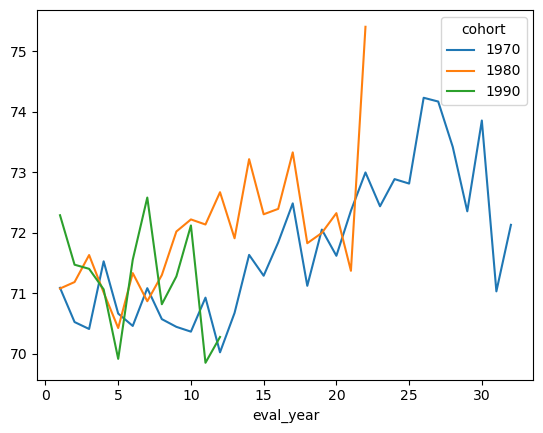

In [88]:
df_cohort.plot()

In [77]:
# grouping the data by training year for 1990 forward
df_year = df_data.groupby(['training_year','eval_year'])['eval_score'].mean()
df_year = df_year.to_frame().dropna().reset_index()
df_year = df_year.pivot(index='eval_year', columns='training_year', values='eval_score')


In [82]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 1 to 32
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1970    32 non-null     float64
 1   1971    31 non-null     float64
 2   1972    30 non-null     float64
 3   1973    29 non-null     float64
 4   1974    28 non-null     float64
 5   1975    27 non-null     float64
 6   1976    26 non-null     float64
 7   1977    25 non-null     float64
 8   1978    24 non-null     float64
 9   1979    23 non-null     float64
 10  1980    22 non-null     float64
 11  1981    21 non-null     float64
 12  1982    20 non-null     float64
 13  1983    19 non-null     float64
 14  1984    18 non-null     float64
 15  1985    17 non-null     float64
 16  1986    16 non-null     float64
 17  1987    15 non-null     float64
 18  1988    14 non-null     float64
 19  1989    13 non-null     float64
 20  1990    12 non-null     float64
 21  1992    10 non-null     float64
 22  1994

In [84]:
df_year = df_year.loc[:, ["1990"]]


KeyError: "None of [Index(['1990'], dtype='object', name='training_year')] are in the [columns]"